In [22]:
torch.optim.Adam()

torch.Size([32, 500, 512])

In [1]:
!pip install celluloid

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import json
import regex
import os
from tqdm.notebook import tqdm
import math
from IPython.display import HTML, clear_output
from celluloid import Camera
import gc

In [3]:
# MatplotLib Global Settings
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 24

In [4]:
# Read Character to Ordinal Encoding Mapping
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    char2ord = json.load(json_file)

display(pd.Series(char2ord).to_frame('Ordinal Encoding'))

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4
&,5
',6
(,7
),8
*,9


In [5]:
# If Notebook Is Run By Committing or In Interactive Mode For Development
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'

PERCENTILES = [0.0, 0.1, 0.25, 0.5, 0.75, 0.97, 0.99]

SEED = 42

no_unique_char_tokens = len(char2ord)
SOS_TOKEN = len(char2ord) + 1
EOS_TOKEN = len(char2ord) + 2

In [6]:
train_df = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
display(train_df.head())
print('Number of samples:', len(train_df))

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


Number of samples: 67208


In [7]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67208 entries, 0 to 67207
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            67208 non-null  object
 1   file_id         67208 non-null  int64 
 2   sequence_id     67208 non-null  int64 
 3   participant_id  67208 non-null  int64 
 4   phrase          67208 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB
None


No empty rows

In [8]:
train_df['phrase_len'] = train_df['phrase'].apply(len)
max_phrase_len = train_df['phrase_len'].max()
print('Maximum phrase length:', max_phrase_len)

Maximum phrase length: 31


In [9]:
sequence_id = train_df.set_index('sequence_id')
display(sequence_id)

,path,file_id,participant_id,phrase,phrase_len
sequence_id,,,,,
1816796431,train_landmarks/5414471.parquet,5414471,217,3 creekhouse,12
1816825349,train_landmarks/5414471.parquet,5414471,107,scales/kuhaylah,15
1816909464,train_landmarks/5414471.parquet,5414471,1,1383 william lanier,19
1816967051,train_landmarks/5414471.parquet,5414471,63,988 franklin lane,17
1817123330,train_landmarks/5414471.parquet,5414471,89,6920 northeast 661st road,25
...,...,...,...,...,...
388192924,train_landmarks/2118949241.parquet,2118949241,88,431-366-2913,12
388225542,train_landmarks/2118949241.parquet,2118949241,154,994-392-3850,12
388232076,train_landmarks/2118949241.parquet,2118949241,95,https://www.tianjiagenomes.com,30


In [10]:
print('Number of parquet files:',len(np.unique(train_df['path'])))

Number of parquet files: 68


In [11]:
def file_paths(path):
    return f'/kaggle/input/asl-fingerspelling/{path}'
train_df['file_paths'] = train_df['path'].apply(file_paths)
display(train_df)

,path,file_id,sequence_id,participant_id,phrase,phrase_len,file_paths
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,12,/kaggle/input/asl-fingerspelling/train_landmar...
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,15,/kaggle/input/asl-fingerspelling/train_landmar...
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,19,/kaggle/input/asl-fingerspelling/train_landmar...
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,17,/kaggle/input/asl-fingerspelling/train_landmar...
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,25,/kaggle/input/asl-fingerspelling/train_landmar...
...,...,...,...,...,...,...,...
67203,train_landmarks/2118949241.parquet,2118949241,388192924,88,431-366-2913,12,/kaggle/input/asl-fingerspelling/train_landmar...
67204,train_landmarks/2118949241.parquet,2118949241,388225542,154,994-392-3850,12,/kaggle/input/asl-fingerspelling/train_landmar...
67205,train_landmarks/2118949241.parquet,2118949241,388232076,95,https://www.tianjiagenomes.com,30,/kaggle/input/asl-fingerspelling/train_landmar...
67206,train_landmarks/2118949241.parquet,2118949241,388235284,36,90 kerwood circle,17,/kaggle/input/asl-fingerspelling/train_landmar...


# Analysis of Phrases

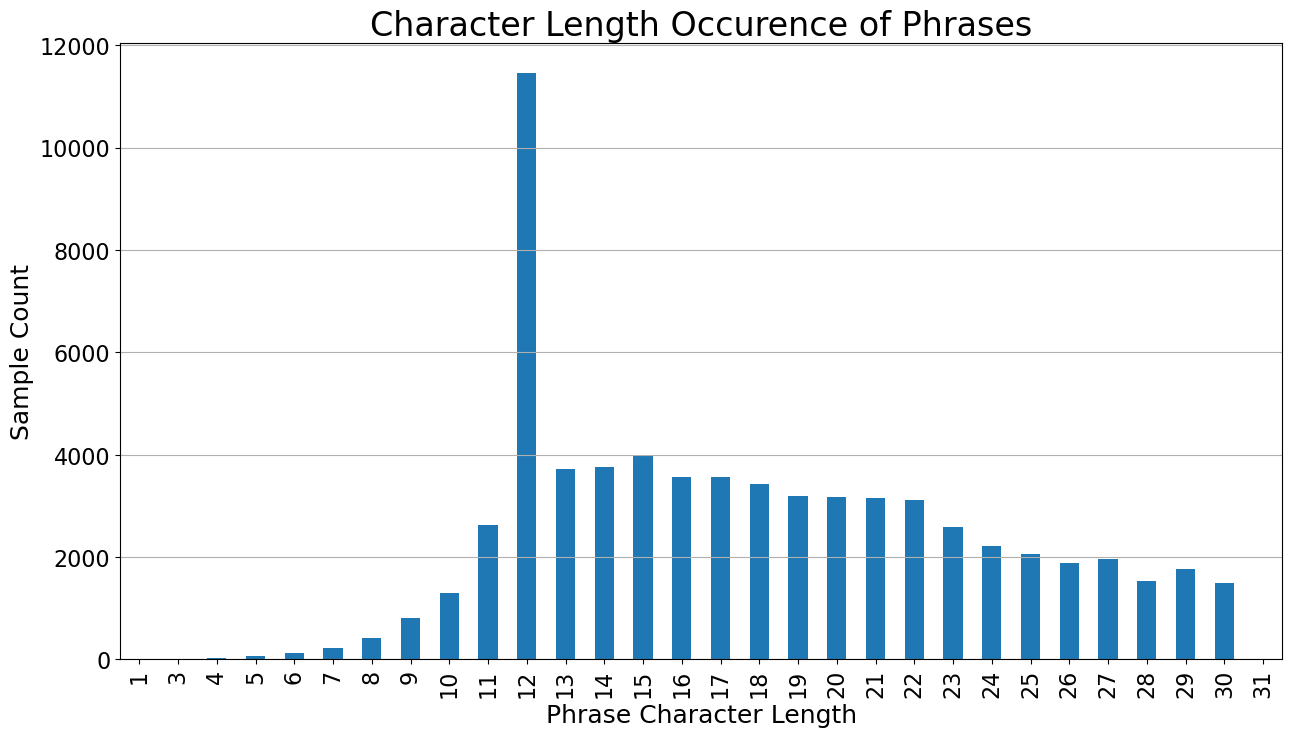

In [12]:
# Character Count Occurence
plt.figure(figsize=(15,8))
plt.title('Character Length Occurence of Phrases')
train_df['phrase_len'].value_counts().sort_index().plot(kind='bar')
plt.xlim(-0.50, train_df['phrase_len'].max() - 1.50)
plt.xlabel('Phrase Character Length')
plt.ylabel('Sample Count')
plt.grid(axis='y')
plt.show()

In [13]:
# Phrase Character Length Statistics
display(train_df['phrase_len'].describe(percentiles=PERCENTILES).to_frame().round(1))
print('Maximum phrase length:', train_df['phrase_len'].max())

,phrase_len
count,67208.0
mean,17.8
std,5.7
min,1.0
0%,1.0
10%,12.0
25%,12.0
50%,17.0
75%,22.0
97%,29.0


Maximum phrase length: 31


# Analysis of Sequences and frames

In [14]:
landmark_df = pd.read_parquet(train_df['file_paths'][0])
display(landmark_df)

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,0.711059,0.700858,0.706272,0.693285,0.700825,0.703319,0.711549,0.615606,0.715143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,0.712799,0.702518,0.707840,0.694899,0.702445,0.704794,0.712483,0.625044,0.715677,...,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
1816796431,4,0.712349,0.705451,0.709918,0.696006,0.705180,0.706928,0.712685,0.614356,0.714875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848182207,296,0.657136,0.635888,0.643259,0.619031,0.633084,0.631827,0.630708,0.533120,0.626672,...,-0.143147,-0.139659,-0.066276,-0.130910,-0.127341,-0.106674,-0.083439,-0.124994,-0.119394,-0.101404
1848182207,297,0.655706,0.635570,0.642730,0.618637,0.632830,0.631554,0.630344,0.531868,0.626445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1848182207,298,0.653681,0.636057,0.643054,0.618643,0.633258,0.631800,0.630059,0.531178,0.625990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
landmark_df.columns

Index(['frame', 'x_face_0', 'x_face_1', 'x_face_2', 'x_face_3', 'x_face_4',
       'x_face_5', 'x_face_6', 'x_face_7', 'x_face_8',
       ...
       'z_right_hand_11', 'z_right_hand_12', 'z_right_hand_13',
       'z_right_hand_14', 'z_right_hand_15', 'z_right_hand_16',
       'z_right_hand_17', 'z_right_hand_18', 'z_right_hand_19',
       'z_right_hand_20'],
      dtype='object', length=1630)

In [16]:
# Number of parquet chunks to analyse
N = 5 if IS_INTERACTIVE else 25

N_UNIQUE_FRAMES = []
UNIQUE_FILE_PATHS = pd.Series(train_df['file_paths'].unique())

for file in UNIQUE_FILE_PATHS.sample(N, random_state=SEED):
    df = pd.read_parquet(file)
    for group, group_df in landmark_df.groupby(by='sequence_id'):
        N_UNIQUE_FRAMES.append(group_df['frame'].nunique())

# Convert to Numpy Array
N_UNIQUE_FRAMES = np.array(N_UNIQUE_FRAMES)

,Value
count,5000
mean,162
std,87
min,1
0%,1
10%,66
25%,104
50%,148
75%,208
97%,355


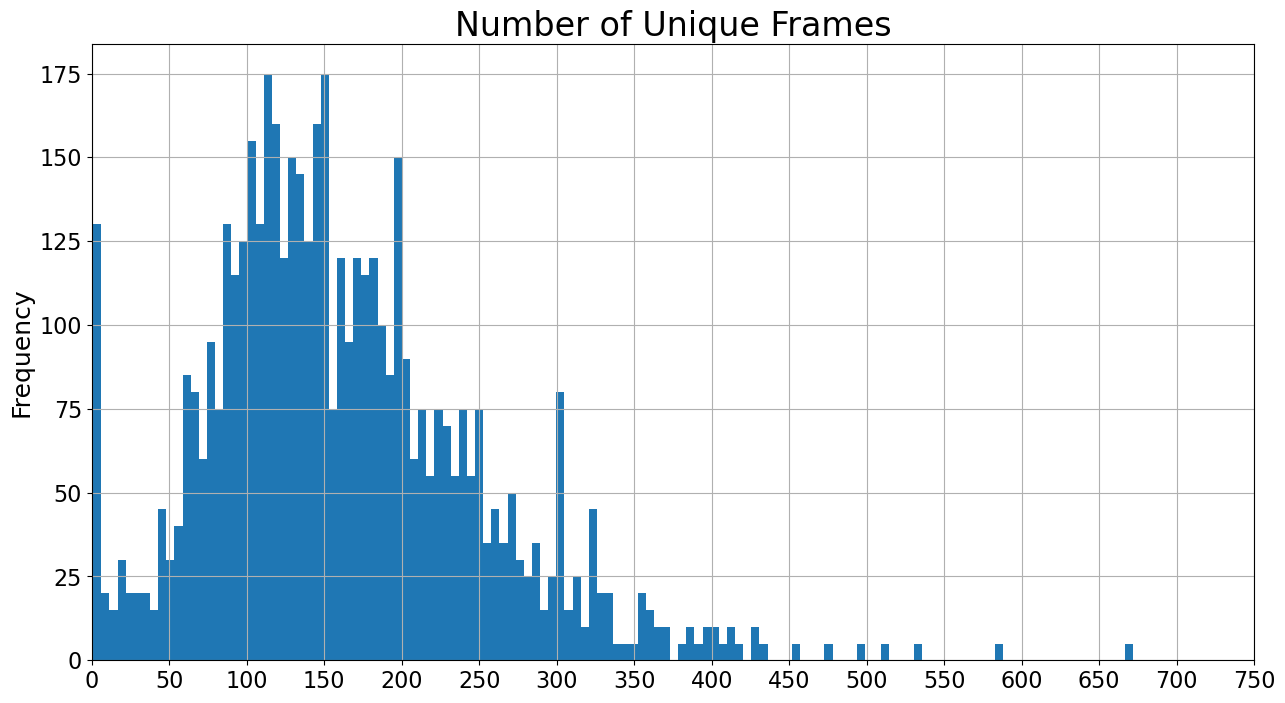

In [17]:
# Number of unique frames in each video
display(pd.Series(N_UNIQUE_FRAMES).describe(percentiles=PERCENTILES).to_frame('Value').astype(int))

plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+50, 50))
plt.show()

In [18]:
def plot_hands(x, y):
    graphs = [[0,1,2,3,4],
             [0,5,6,7,8],
              [5,9,13,17],
             [9,10,11,12],
              [13,14,15,16],
              [0,17,18,19,20]]
    
    for g1 in graphs:
        plt.plot(x[g1], y[g1])
    #plt.show()

In [19]:
def plot_sample(seq_id, n_frames = None):
    x_test_right = landmark_df.filter(regex = 'x_right_hand')[landmark_df.index == seq_id].dropna()
    y_test_right = landmark_df.filter(regex = 'y_right_hand')[landmark_df.index == seq_id].dropna()
    camera = Camera(plt.figure())

    for i in range(x_test_right.shape[0]):
        x_r = 1 - x_test_right.iloc[i].values
        y_r = 1 - y_test_right.iloc[i].values
        plot_hands(x_r, y_r)
        camera.snap()
    anim = camera.animate().to_html5_video()
    return anim

In [20]:
#ind = np.random.choice(np.unique(landmark_df.index))
ind = np.unique(landmark_df.index)[0]
HTML(plot_sample(ind))

In [21]:
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(landmark_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx) 
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [22]:
# Lips Landmark Face Ids
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(landmark_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(landmark_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(landmark_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [23]:
def hands(landmark_df):
    MAX_FRAMES = 500

    # Extract x and y coordinate columns of the right hand
    right_hand_columns = landmark_df.filter(regex='x_right_hand_|y_right_hand_')

    # Extract x and y coordinate columns of the left hand
    left_hand_columns = landmark_df.filter(regex='x_left_hand_|y_left_hand_')

    # Concatenate the right hand and left hand columns
    hand_columns = pd.concat([right_hand_columns, left_hand_columns], axis=1).groupby(by='sequence_id')

    for group_name, group_df in hand_columns:
        #if len(group_df)<MAX_FRAMES:

            # Specify the number of empty rows to add
            #num_empty_rows = MAX_FRAMES-len(group_df)
            #new_index = pd.Index([group_name] * num_empty_rows)

            # Create an empty DataFrame with the desired number of rows
            #empty_rows = pd.DataFrame(index=new_index, columns=group_df.columns)

            # Concatenate the original DataFrame with the empty rows DataFrame
            #group_df = pd.concat([group_df, empty_rows])
       # else:
            #group_df = group_df[:MAX_FRAMES]
        #group_df = group_df.fillna(0)
        result = train_df.loc[train_df['sequence_id'] == group_name, 'phrase'].values[0]
        sequence_phrases.append(result)
        frames.append(group_df)

In [24]:
sequence_phrases = []
frames = []
for idx, file in enumerate(tqdm(train_df['file_paths'].unique())):
    landmark_df = pd.read_parquet(file)
    hands(landmark_df)
    clear_output(wait=True)
    gc.collect()

  0%|          | 0/68 [00:00<?, ?it/s]

In [25]:
"""display(np.array(frames).shape)
display(np.array(sequence_phrases).shape)"""

'display(np.array(frames).shape)\ndisplay(np.array(sequence_phrases).shape)'

In [26]:
frames_array = np.array(frames)
phrase_array = np.array(sequence_phrases)

/tmp/ipykernel_33/4109078389.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frames_array = np.array(frames)


In [27]:
gc.collect()

18

In [39]:
display(frames[0])
display(sequence_phrases[0])

,x_right_hand_0,x_right_hand_1,x_right_hand_2,x_right_hand_3,x_right_hand_4,x_right_hand_5,x_right_hand_6,x_right_hand_7,x_right_hand_8,x_right_hand_9,...,y_left_hand_11,y_left_hand_12,y_left_hand_13,y_left_hand_14,y_left_hand_15,y_left_hand_16,y_left_hand_17,y_left_hand_18,y_left_hand_19,y_left_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0.408832,0.519912,0.612159,0.707576,0.797313,0.494709,0.532817,0.553556,0.566219,0.391196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,0.398663,0.523662,0.638807,0.744236,0.832567,0.538486,0.564302,0.581011,0.597674,0.441541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'3 creekhouse'

In [28]:
np.save('X.npy', frames_array)
np.save('Y.npy', phrase_array)